In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import image_analysis as ia # module with most of the code

%matplotlib notebook

## Extract frames from video

This needs to be done only once for every video

In [2]:
path = './T-data/18-11/'
video_name = 'B-ol10-aq30-spf1.wmv'

ia.extract_frames(path, video_name)

FileNotFoundError: No such file or directory

## Get arrays from video

In [2]:
folder = './T-data/18-11/B-ol10-aq30-spf1'

color = 1 # green

arrays, mean_array = ia.get_arrays(folder,color)

print(arrays.shape)

Image.fromarray(mean_array).show()

(299, 960, 1280)


## Subtract the mean

In [3]:
arrays_sub = ia.subtract_mean(arrays,mean_array)

m = -145.0, M = 154.0
Subtracting the bias will generate some overflow
Rescale arrays to avoid overflow? [y/n] y


In [79]:
# see an example

idx = 9

Image.fromarray(arrays[idx]).show()
Image.fromarray(arrays_sub[idx]).show()

## Rotation and gaussian filter

In [5]:
# test on one image

rotation = 32
filter_size = 3

img = ia.preprocess(arrays_sub[idx], rotation=rotation, filter_size=filter_size)
img.show()

In [6]:
# apply to all images
imgs = []
for array_sub in tqdm(arrays_sub):
    imgs.append(ia.preprocess(array_sub, rotation=rotation, filter_size=filter_size))

imgs = np.array(imgs,dtype=Image.Image)
# calibration image
calibr_img = ia.preprocess(arrays[idx], rotation=rotation, filter_size=0) # keep the image sharp

calibr_img.show()

100%|██████████| 299/299 [00:14<00:00, 20.13it/s]


## Channel analyzer

### Calibrate

In [7]:
c = ia.Channel_analyzer()

<IPython.core.display.Javascript object>


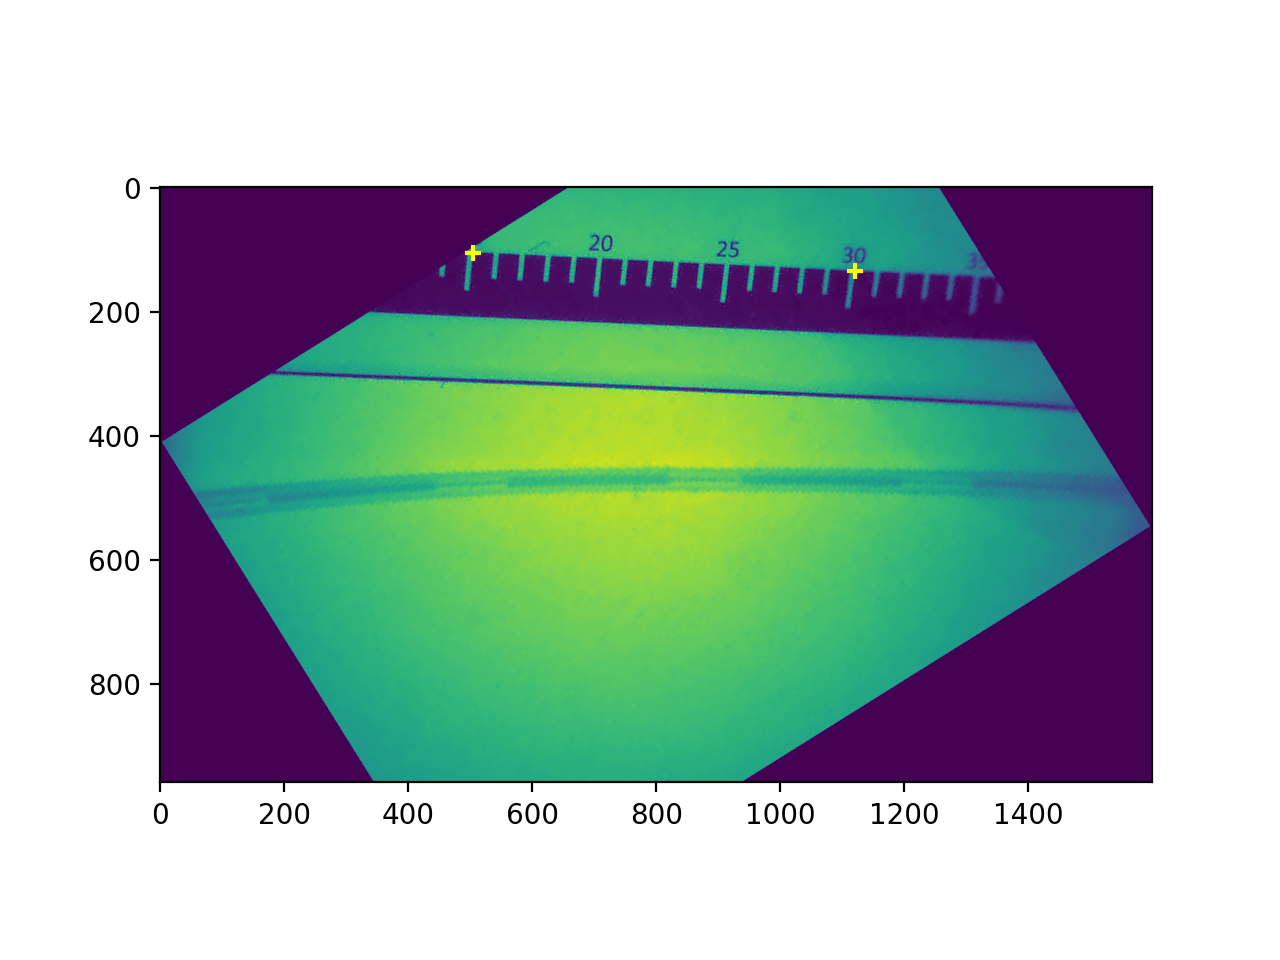

In [15]:
c.calibrate(calibr_img,15)

<IPython.core.display.Javascript object>


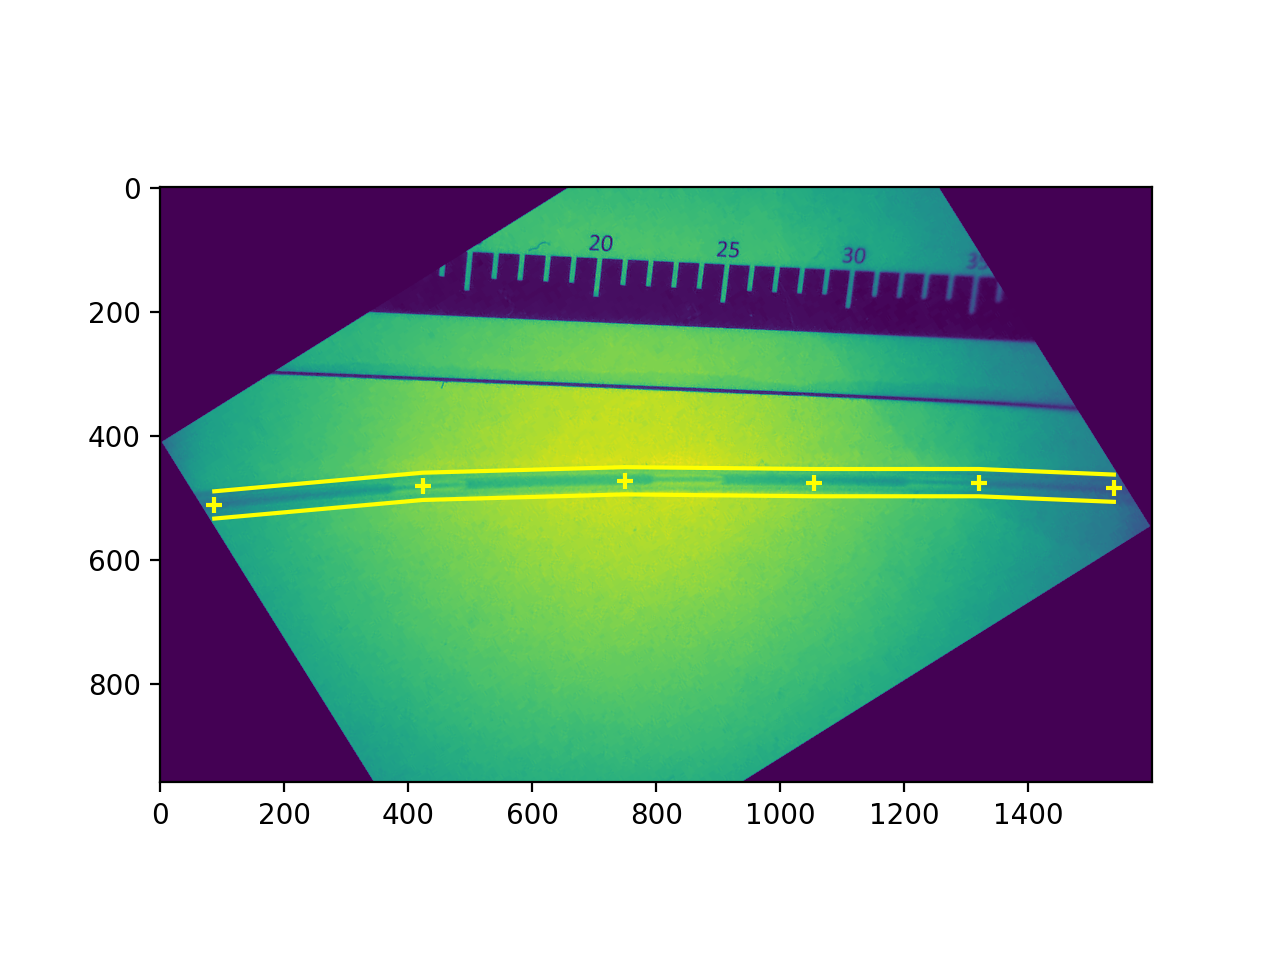

In [9]:
c.find_channel(calibr_img)

### Save calibration

In [16]:
c.save(name='calibr_B-ol10-aq30',folder='./T-data/18-11/')

./T-data/18-11/calibr_B-ol10-aq30 exists: overwrite? [y/n]n


### Load from existing calibration

In [8]:
c.load(name='calibr_B-ol10-aq30',folder='./T-data/18-11')

### Try analysis on one image

<IPython.core.display.Javascript object>


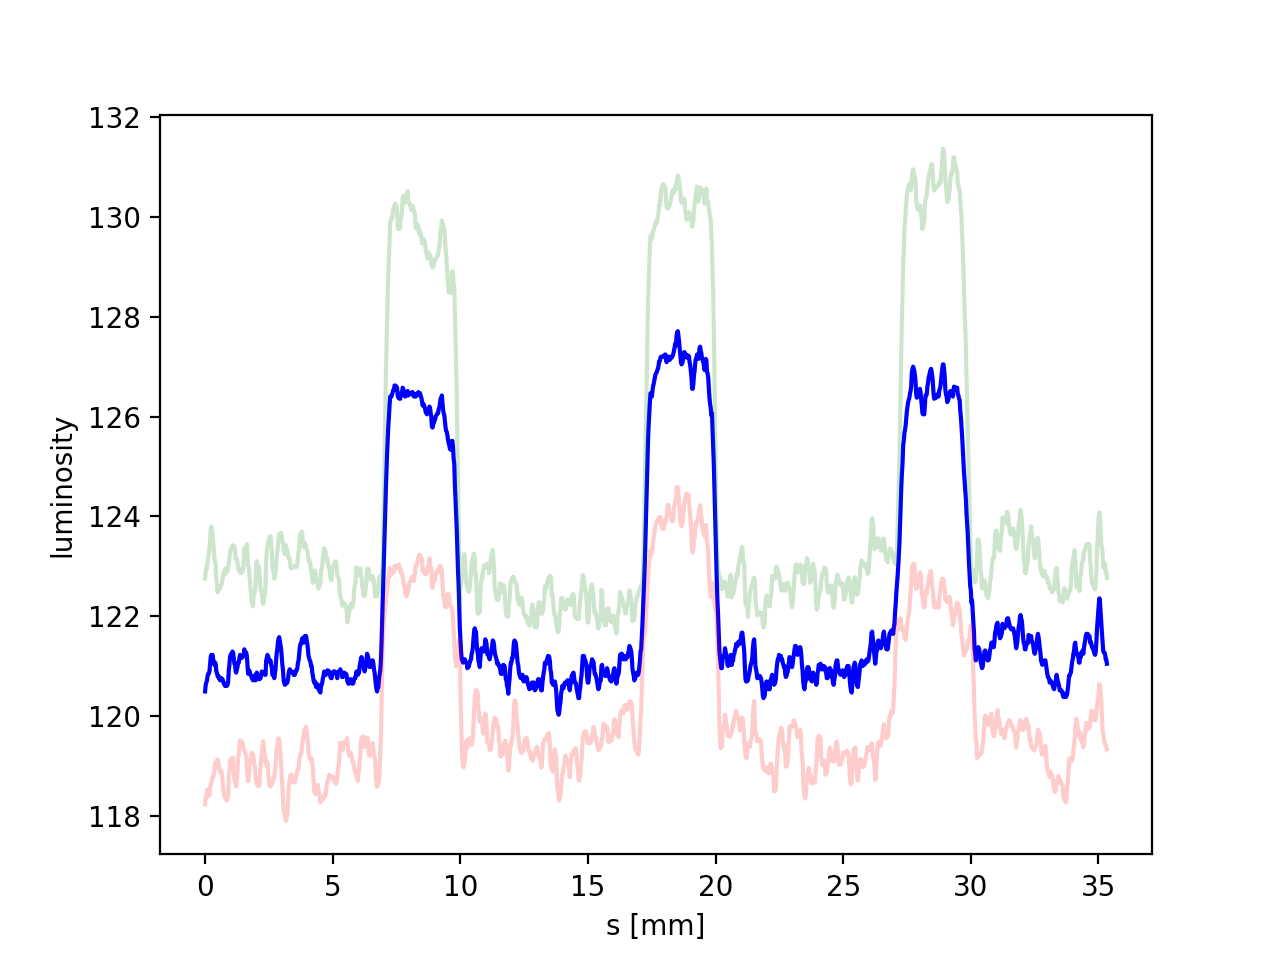

Text(0, 0.5, 'luminosity')

In [15]:
idx = 0

img = imgs[idx]
s, mean, std = c.evaluate(img)

plt.figure()
plt.plot(s,mean, color='blue')
plt.plot(s,mean - std,color='red',alpha=0.2)
plt.plot(s,mean + std,color='green',alpha=0.2)

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

## Analyze the waveforms

In [10]:
s = 0.

means = []
stds = []

for idx in tqdm(range(len(imgs))):
    s, mean, std = c.evaluate(imgs[idx])
    means.append(mean)
    stds.append(std)

100%|██████████| 299/299 [00:21<00:00, 14.03it/s]


In [16]:
def thr_searcher(Data, nbins, thr_low, thr_high, color, t=None):
    
    # Histogram definition
    freq,bins,p = plt.hist(Data, nbins, color=color)
    x = 0.5 *(bins[:-1] + bins[1:])
    plt.clf() # Clear figure
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    from lmfit.models import GaussianModel

    #Cicle changing center1 position if condition (center1+2*sigma1 < center2-2*sigma2) is not fulfilled
    for i in range(1,6):    

        #linear = LinearModel(prefix='lin_')
        gauss1 = GaussianModel(prefix='g1_')
        pars = gauss1.make_params(center=x[0]+i*(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq)/20)

        #gauss1 = GaussianModel(prefix='g1_')
        #pars.update(gauss1.make_params())

        gauss2 = GaussianModel(prefix='g2_')
        pars.update(gauss2.make_params())

        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        pars['g1_sigma'].set(max=(x[-1]-x[0])/10,min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)

        pars['g2_center'].set(value=x[-1]*0.98)
        pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
        pars['g2_amplitude'].set(value=max(freq)/20,min=10)

        #mod = linear + gauss1 +gauss2
        mod = gauss1 +gauss2

        init = mod.eval(pars, x=x)
        out = mod.fit(freq, pars, x=x)

        # Plot histo
        axes[0].hist(Data, nbins, color=color)
        axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel("Voltage [V]")
        axes[0].set_ylabel("Number of events") 

        center2=out.best_values.get('g2_center')
        sigma2=out.best_values.get('g2_sigma')
        center1=out.best_values.get('g1_center')
        sigma1=out.best_values.get('g1_sigma')

        if center1+2*sigma1 < center2-2*sigma2:
            max_freq1=max(freq[x<center1+sigma1])
            x_max1 = x[np.argmax(freq[x<center1+2*sigma1])]
            max_freq2=max(freq[x>center2-sigma2])
            a=x>center2-sigma2
            freq2=np.zeros(len(freq))
            for i in range(len(a)): 
                if a[i]==True: freq2[i]=freq[i]
            #print(freq2)
            x_max2 = x[np.argmax(freq2)]
            #print('xmax 1: ', x_max1,'\n xmax 2: ',x_max2)
            break
        else: print('trying again')
            
    thr_low  = x_max1 + 2*sigma1
    thr_high = x_max2 - 2*sigma1
    print('thr_low  = ', thr_low,' [V] \nthr_high = ', thr_high, ' [V]')
    
    axes[1].plot(t, Data, color)
    axes[1].plot(thr_high*np.ones(len(t)), color='red')
    axes[1].plot(thr_low*np.ones(len(t)), color='red')
    plt.xlim((0,t[len(t)-1]))
    axes[1].set_title("Signal with thresholds")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_ylabel("Voltage [V]") 
    
    return thr_low, thr_high


def drop_det(time, data, thr_low, thr_high, drop_start, drop_end, ymin, ymax, xrange):
    
    # Drops edges computing
    bool_high  = data > thr_high
    bool_low   = data < thr_low
    drop_start = [0]
    drop_end   = [1]
   
    for i in range(len(data)-1):
        
        if bool_high[i]==False and bool_low[i+1]==False and bool_high[i+1]==True:
            if drop_start[-1] < drop_end[-1] and i > drop_end[-1]:
                drop_start.append(i)
                
        elif bool_low[i]==False and bool_low[i+1]==True and bool_high[i+1]==False:
            if drop_start[-1] > drop_end[-1] and i > drop_start[-1]:
                drop_end.append(i)
 
    # number acquisition -> time [s] conversion
    drop_start = time[drop_start]
    drop_end   = time[drop_end]
    
    #Selection
    drop_start = drop_start[1:]
    drop_end   = drop_end[1:]
    
    #Cropping
    if len(drop_start) > len(drop_end):
        drop_start = drop_start[:-1]
    
    # Plotting 
    for j in range(int (time[-1]/xrange)):
        plt.figure()
        plt.figure(figsize=(20,4))
        for i in range(len(drop_end)):
        
            plt.vlines(drop_start[i], ymin, ymax, color='green')
            plt.vlines(drop_end[i], ymin, ymax, color='red')

        plt.plot(time, data)
        plt.ylabel("Voltage [V]")
        plt.xlabel("Time [s]")
        plt.xlim(j*xrange,(j+1)*xrange)
        plt.ylim(ymin, ymax)
        plt.show()
        
    return drop_start, drop_end
    
    

thr_low  =  122.54905185185184  [V] 
thr_high =  125.57005925925925  [V]


<Figure size 432x288 with 0 Axes>

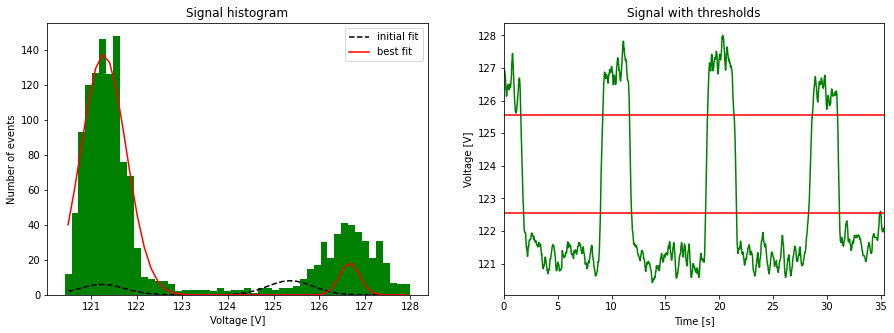

In [22]:
%matplotlib inline

idx = 35

thr_low, thr_high = thr_searcher(means[idx], 50, 0., 0., 'green',s)

thr_low = 122
thr_high = 124

<Figure size 432x288 with 0 Axes>

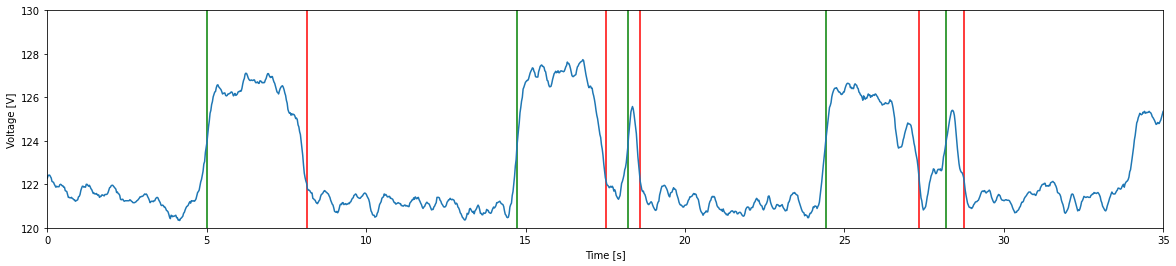

In [81]:
idx = 11

drop_start, drop_end = drop_det(s,means[idx], thr_low, thr_high,0,0,120,130,35)

In [20]:
drop_start, drop_end

(array([ 1.245444  , 11.3443197 , 21.12452439, 30.63571134]),
 array([ 4.15148002, 14.09394612, 23.82457538, 33.43532073]))

In [24]:
# apply to all

drop_starts = []
drop_ends = []

for mean in means:
    drop_start, drop_end = drop_det(s,mean, thr_low, thr_high,0,0,120,130,50)
    
    drop_starts.append(drop_start)
    drop_ends.append(drop_end)

In [27]:
for i,a in enumerate(drop_starts):
    print(i,len(a))

0 3
1 3
2 4
3 4
4 3
5 3
6 4
7 6
8 3
9 6
10 6
11 5
12 4
13 3
14 5
15 4
16 5
17 4
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 4
26 4
27 4
28 3
29 3
30 3
31 4
32 4
33 4
34 4
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 4
49 3
50 3
51 3
52 4
53 3
54 3
55 4
56 3
57 3
58 3
59 3
60 3
61 3
62 4
63 3
64 3
65 3
66 3
67 3
68 3
69 3
70 3
71 3
72 4
73 3
74 3
75 4
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 4
84 3
85 3
86 3
87 4
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 4
101 3
102 4
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 3
112 3
113 4
114 3
115 3
116 3
117 3
118 3
119 3
120 3
121 3
122 4
123 3
124 4
125 3
126 3
127 3
128 3
129 3
130 3
131 3
132 3
133 3
134 3
135 3
136 4
137 3
138 3
139 3
140 3
141 3
142 3
143 3
144 3
145 4
146 3
147 3
148 3
149 3
150 3
151 3
152 4
153 3
154 3
155 3
156 3
157 4
158 3
159 3
160 4
161 3
162 4
163 3
164 4
165 4
166 3
167 3
168 3
169 4
170 3
171 3
172 4
173 3
174 3
175 3
176 3
177 3
178 3
179 4
180 4
181 4
182 3
183 3
184 3


In [29]:
drop_starts[:4]

[array([ 7.03309556, 17.25686871, 27.22989473]),
 array([ 8.59469328, 18.76501118, 28.81093585]),
 array([ 0.07326141, 10.32233465, 20.29747852, 30.29488933]),
 array([ 1.97805812, 12.09864199, 22.0245449 , 31.90162167])]

In [78]:
imgs[9].show()

In [95]:
thr = 6.

vec = drop_starts

diffs = []

for idx in tqdm(range(len(vec) - 1)):
#     print(f' idx {idx}')
    delay_idx = -1
    exit = False
    diffs.append([])
    for i,drop in enumerate(vec[idx]):
#         print(f'drop {drop}')
        diff = 0.
#         print(i)
        while(diff < thr):
            delay_idx += 1
            try:
                diff = vec[idx + 1][delay_idx] - drop
#                 print(diff)
            except(IndexError):
                exit = True
                break
        if exit:
            if len(diffs[-1]) == 1:
                imgs[idx].show()
            break
        diffs[-1].append(diff)
        
        

100%|██████████| 298/298 [00:00<00:00, 501.70it/s]


In [54]:
for i,drop in enumerate(drop_starts[idx]):
    print(f'drop {drop}')

drop 1.978058124895722
drop 12.098641988187412
drop 22.024544895749568
drop 31.90162167406743


In [71]:
np.min(np.concatenate(diffs))

6.000348812474438

Text(0.5, 0, 'velocity [mm/s]')

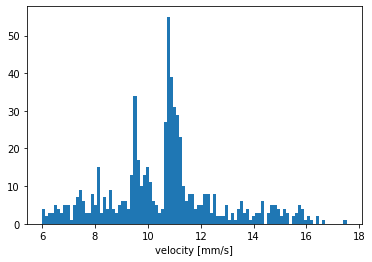

In [87]:
plt.figure()
plt.hist(np.concatenate(diffs),bins = 100)

plt.xlabel('velocity [mm/s]')

Text(0, 0.5, 'velocity [mm/s]')

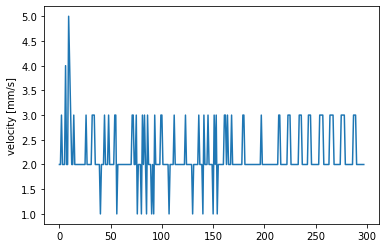

In [94]:
plt.figure()
plt.plot([len(diff) for diff in diffs])

plt.ylabel('velocity [mm/s]')